<a href="https://colab.research.google.com/github/rubanzasilva/RossmanSales/blob/master/rossman_sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ROSSMANN SALES SOLUTION

Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

IMPORTS

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
import seaborn as sns
from pathlib import Path
import PIL
import json
from fastai import *
from fastai.tabular import *
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.basics import *





**LOAD KAGGLE DATASET**

In [0]:
! git clone https://github.com/rubanzasilva/external.git

Cloning into 'external'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 15 (delta 3), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (15/15), done.


In [0]:
PATH = Path('rossmann/')
PATH


PosixPath('rossmann')

In [0]:
!ls 

external  sample_data


In [0]:
!unzip external/rossmann.zip

Archive:  external/rossmann.zip
   creating: rossmann/
  inflating: rossmann/state_names.csv  
   creating: __MACOSX/
   creating: __MACOSX/rossmann/
  inflating: __MACOSX/rossmann/._state_names.csv  
  inflating: rossmann/googletrend.csv  
  inflating: __MACOSX/rossmann/._googletrend.csv  
  inflating: rossmann/test.csv       
  inflating: __MACOSX/rossmann/._test.csv  
  inflating: rossmann/weather.csv    
  inflating: __MACOSX/rossmann/._weather.csv  
  inflating: rossmann/train.csv      
  inflating: __MACOSX/rossmann/._train.csv  
  inflating: rossmann/store_states.csv  
  inflating: __MACOSX/rossmann/._store_states.csv  
  inflating: rossmann/store.csv      
  inflating: __MACOSX/rossmann/._store.csv  
  inflating: rossmann/sample_submission.csv  
  inflating: __MACOSX/rossmann/._sample_submission.csv  
  inflating: __MACOSX/._rossmann     


**LOAD INTO DATAFRAME**

In [0]:
PATH=Path('rossmann/')

In [0]:
def concat_csvs(dirname):
    path = f'{PATH}{dirname}'
    filenames=glob(f"{PATH}/*.csv")

    wrote_header = False
    with open(f"{path}.csv","w") as outputfile:
        for filename in filenames:
            name = filename.split(".")[0]
            with open(filename) as f:
                line = f.readline()
                if not wrote_header:
                    wrote_header = True
                    outputfile.write("file,"+line)
                for line in f:
                     outputfile.write(name + "," + line)
                outputfile.write("\n")

In [0]:
table_names = ['train', 'store', 'store_states', 'state_names', 'googletrend', 'weather', 'test']
tables = [pd.read_csv(PATH/f'{fname}.csv', low_memory=False) for fname in table_names]
train, store, store_states, state_names, googletrend, weather, test = tables
len(train),len(test)

(1017209, 41088)

**DATA CLEAN**

In [0]:
#turn state holidays to boolean
train.StateHoliday = train.StateHoliday!= '0'
test.StateHoliday = test.StateHoliday!= '0'

join tables

In [0]:
def join_df(left , right , left_on , right_on=None , suffix='_y'):
  if right_on is None: right_on = left_on
  return left.merge(right , how='left' , left_on = left_on , right_on = right_on , suffixes=("", suffix))

In [0]:
#join weather and state names
weather = join_df(weather, state_names , "file" , "StateName")

In [0]:
googletrend['Date'] = googletrend.week.str.split(' - ', expand=True)[0]
googletrend['State'] = googletrend.file.str.split('_', expand=True)[2]
googletrend.loc[googletrend.State=='NI', "State"] = 'HB,NI'

Extract Date Fields

In [0]:
def add_datepart(df, fldname, drop=True, time=False):
    "Helper function that adds columns relevant to a date."
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [0]:
add_datepart(weather, "Date", drop=False)
add_datepart(googletrend, "Date", drop=False)
add_datepart(train, "Date", drop=False)
add_datepart(test, "Date", drop=False)

In [0]:
trend_de = googletrend[googletrend.file == 'Rossmann_DE']

In [0]:
#outer join followed by null-check
#we do outta join to because data might have unfilled values
store = join_df(store, store_states, "Store")
len(store[store.State.isnull()])

0

In [0]:
joined = join_df(train, store, "Store")
joined_test = join_df(test, store, "Store")
len(joined[joined.StoreType.isnull()]),len(joined_test[joined_test.StoreType.isnull()])

(0, 0)

In [0]:
joined = join_df(joined, googletrend, ["State","Year", "Week"])
joined_test = join_df(joined_test, googletrend, ["State","Year", "Week"])
len(joined[joined.trend.isnull()]),len(joined_test[joined_test.trend.isnull()])

(0, 0)

In [0]:
joined = joined.merge(trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
joined_test = joined_test.merge(trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
len(joined[joined.trend_DE.isnull()]),len(joined_test[joined_test.trend_DE.isnull()])

(0, 0)

In [0]:
joined = join_df(joined, weather, ["State","Date"])
joined_test = join_df(joined_test, weather, ["State","Date"])
len(joined[joined.Mean_TemperatureC.isnull()]),len(joined_test[joined_test.Mean_TemperatureC.isnull()])

(0, 0)

In [0]:
for df in (joined, joined_test):
    for c in df.columns:
        if c.endswith('_y'):
            if c in df.columns: df.drop(c, inplace=True, axis=1)

Fill in missing values

In [0]:
for df in (joined,joined_test):
    df['CompetitionOpenSinceYear'] = df.CompetitionOpenSinceYear.fillna(1900).astype(np.int32)
    df['CompetitionOpenSinceMonth'] = df.CompetitionOpenSinceMonth.fillna(1).astype(np.int32)
    df['Promo2SinceYear'] = df.Promo2SinceYear.fillna(1900).astype(np.int32)
    df['Promo2SinceWeek'] = df.Promo2SinceWeek.fillna(1).astype(np.int32)

In [0]:
for df in (joined,joined_test):
    df["CompetitionOpenSince"] = pd.to_datetime(dict(year=df.CompetitionOpenSinceYear, 
                                                     month=df.CompetitionOpenSinceMonth, day=15))
    df["CompetitionDaysOpen"] = df.Date.subtract(df.CompetitionOpenSince).dt.days

In [0]:
#replace outliers
for df in (joined,joined_test):
    df.loc[df.CompetitionDaysOpen<0, "CompetitionDaysOpen"] = 0
    df.loc[df.CompetitionOpenSinceYear<1990, "CompetitionDaysOpen"] = 0

In [0]:
#We add "CompetitionMonthsOpen" field
for df in (joined,joined_test):
    df["CompetitionMonthsOpen"] = df["CompetitionDaysOpen"]//30
    df.loc[df.CompetitionMonthsOpen>24, "CompetitionMonthsOpen"] = 24
joined.CompetitionMonthsOpen.unique()


array([24,  3, 19,  9,  0, 16, 17,  7, 15, 22, 11, 13,  2, 23, 12,  4, 10,  1, 14, 20,  8, 18,  6, 21,  5])

promo dates

In [0]:
! pip install isoweek

In [0]:
from isoweek import Week
for df in (joined,joined_test):
    df["Promo2Since"] = pd.to_datetime(df.apply(lambda x: Week(
        x.Promo2SinceYear, x.Promo2SinceWeek).monday(), axis=1))
    df["Promo2Days"] = df.Date.subtract(df["Promo2Since"]).dt.days

In [0]:
for df in (joined,joined_test):
    df.loc[df.Promo2Days<0, "Promo2Days"] = 0
    df.loc[df.Promo2SinceYear<1990, "Promo2Days"] = 0
    df["Promo2Weeks"] = df["Promo2Days"]//7
    df.loc[df.Promo2Weeks<0, "Promo2Weeks"] = 0
    df.loc[df.Promo2Weeks>25, "Promo2Weeks"] = 25
    df.Promo2Weeks.unique()

In [0]:
joined.to_pickle(PATH/'joined')
joined_test.to_pickle(PATH/'joined_test')

**DURATION**//
Extract data explaining relationships across rows


we've created a class to handle this type of data.

We'll define a function get_elapsed for cumulative counting across a sorted dataframe. Given a particular field fld to monitor, this function will start tracking time since the last occurrence of that field. When the field is seen again, the counter is set to zero.

Upon initialization, this will result in datetime na's until the field is encountered. This is reset every time a new store is seen. We'll see how to use this shortly.



In [0]:
def get_elapsed(fld, pre):
    day1 = np.timedelta64(1, 'D')
    last_date = np.datetime64()
    last_store = 0
    res = []

    for s,v,d in zip(df.Store.values,df[fld].values, df.Date.values):
        if s != last_store:
            last_date = np.datetime64()
            last_store = s
        if v: last_date = d
        res.append(((d-last_date).astype('timedelta64[D]') / day1))
    df[pre+fld] = res

In [0]:
columns = ["Date", "Store", "Promo", "StateHoliday", "SchoolHoliday"]

In [0]:
#df = train[columns]
df = train[columns].append(test[columns])

Let's walk through an example.

Say we're looking at School Holiday. We'll first sort by Store, then Date, and then call add_elapsed('SchoolHoliday', 'After'): This will apply to each row with School Holiday:

A applied to every row of the dataframe in order of store and date
Will add to the dataframe the days since seeing a School Holiday
If we sort in the other direction, this will count the days until another holiday.

In [0]:
fld = 'SchoolHoliday'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

In [0]:
fld = 'StateHoliday'
df = df.sort_values(['Store' , 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store' , 'Date'] , ascending=[True , False])
get_elapsed(fld, 'Before')

In [0]:
fld = 'Promo'
df = df.sort_values(['Store' , 'Date'])
get_elapsed(fld , 'After')
df = df.sort_values(['Store' , 'Date'] , ascending=[True , False])
get_elapsed(fld , 'Before')

In [0]:
df = df.set_index("Date")

In [0]:
columns = ['SchoolHoliday' , 'StateHoliday' , 'Promo']

In [0]:
for o in ['Before' , 'After']:
  for p in columns:
    a = o+p
    df[a] = df[a].fillna(0).astype(int)

In [0]:
bwd = df[['Store']+columns].sort_index().groupby("Store").rolling(7, min_periods=1).sum()

In [0]:
fwd = df[['Store']+columns].sort_index(ascending=False
                                      ).groupby("Store").rolling(7, min_periods=1).sum()

In [0]:
bwd.drop('Store',1,inplace=True)
bwd.reset_index(inplace=True)

In [0]:
fwd.drop('Store',1,inplace=True)
fwd.reset_index(inplace=True)

In [0]:
df.reset_index(inplace=True)

In [0]:
df = df.merge(bwd, 'left', ['Date', 'Store'], suffixes=['', '_bw'])
df = df.merge(fwd, 'left', ['Date', 'Store'], suffixes=['', '_fw'])

In [0]:
df.drop(columns,1,inplace=True)

In [0]:
df.head()

,Date,Store,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw
0,2015-09-17,1,13,0,105,0,0,0,0.0,0.0,4.0,0.0,0.0,1.0
1,2015-09-16,1,12,0,104,0,0,0,0.0,0.0,3.0,0.0,0.0,2.0
2,2015-09-15,1,11,0,103,0,0,0,0.0,0.0,2.0,0.0,0.0,3.0
3,2015-09-14,1,10,0,102,0,0,0,0.0,0.0,1.0,0.0,0.0,4.0
4,2015-09-13,1,9,0,101,0,9,-1,0.0,0.0,0.0,0.0,0.0,4.0


In [0]:
df.to_pickle(PATH/'df')

In [0]:
df = pd.read_pickle(PATH/'df')


In [0]:
df

,Date,Store,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw
0,2015-09-17,1,13,0,105,0,0,0,0.0,0.0,4.0,0.0,0.0,1.0
1,2015-09-16,1,12,0,104,0,0,0,0.0,0.0,3.0,0.0,0.0,2.0
2,2015-09-15,1,11,0,103,0,0,0,0.0,0.0,2.0,0.0,0.0,3.0
3,2015-09-14,1,10,0,102,0,0,0,0.0,0.0,1.0,0.0,0.0,4.0
4,2015-09-13,1,9,0,101,0,9,-1,0.0,0.0,0.0,0.0,0.0,4.0
5,2015-09-12,1,8,0,100,0,8,-2,0.0,0.0,0.0,0.0,0.0,4.0
6,2015-09-11,1,7,0,99,0,7,-3,0.0,0.0,0.0,0.0,0.0,4.0
7,2015-09-10,1,6,0,98,0,6,-4,1.0,0.0,1.0,0.0,0.0,3.0
8,2015-09-09,1,5,0,97,0,5,-5,2.0,0.0,2.0,0.0,0.0,2.0
9,2015-09-08,1,4,0,96,0,4,-6,3.0,0.0,3.0,0.0,0.0,1.0


In [0]:
df["Date"] = pd.to_datetime(df.Date)

In [0]:
df.columns

Index(['Date', 'Store', 'AfterSchoolHoliday', 'BeforeSchoolHoliday',
       'AfterStateHoliday', 'BeforeStateHoliday', 'AfterPromo', 'BeforePromo',
       'SchoolHoliday_bw', 'StateHoliday_bw', 'Promo_bw', 'SchoolHoliday_fw',
       'StateHoliday_fw', 'Promo_fw'],
      dtype='object')

In [0]:
joined = pd.read_pickle(PATH/'joined')
joined_test = pd.read_pickle(PATH/f'joined_test')

In [0]:
joined = join_df(joined, df, ['Store', 'Date'])

In [0]:
joined_test = join_df(joined_test, df, ['Store', 'Date'])

In [0]:
joined = joined[joined.Sales!=0]

In [0]:
joined.reset_index(inplace=True)
joined_test.reset_index(inplace=True)

In [0]:
joined.to_pickle(PATH/'train_clean')
joined_test.to_pickle(PATH/'test_clean')

load into df

In [0]:
path = Config().data_path()/'rossmann'

In [0]:
train_df = pd.read_pickle(PATH/'train_clean')

In [0]:
test_df = pd.read_pickle(PATH/'test_clean')

In [0]:
train_df.head().T

,0,1,2,3,4
index,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Sales,5263,6064,8314,13995,4822
Customers,555,625,821,1498,559
Open,1,1,1,1,1
Promo,1,1,1,1,1
StateHoliday,False,False,False,False,False
SchoolHoliday,1,1,1,1,1


In [0]:
n = len(train_df)
n

844338

In [0]:
train_df = pd.read_pickle(PATH/'train_clean')
test_df = pd.read_pickle(PATH/'test_clean')

In [0]:
len(train_df),len(test_df)

(844338, 41088)

In [0]:
procs = [FillMissing, Categorify, Normalize]

In [0]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

cont_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

In [0]:
dep_var = 'Sales'
df = train_df[cat_vars + cont_vars + [dep_var,'Date']].copy()

In [0]:
test_df['Date'].min(), test_df['Date'].max()

(Timestamp('2015-08-01 00:00:00'), Timestamp('2015-09-17 00:00:00'))

In [0]:
cut = train_df['Date'][(train_df['Date'] == train_df['Date'][len(test_df)])].index.max()
cut

41395

In [0]:
valid_idx = range(cut)

In [0]:
df[dep_var].head()

0     5263
1     6064
2     8314
3    13995
4     4822
Name: Sales, dtype: int64

sample

In [0]:
idx = np.random.permutation(range(n))[:2000]
idx.sort()
small_train_df = train_df.iloc[idx[:1000]]
small_test_df = train_df.iloc[idx[1000:]]
small_cont_vars = ['CompetitionDistance', 'Mean_Humidity']
small_cat_vars =  ['Store', 'DayOfWeek', 'PromoInterval']
small_train_df = small_train_df[small_cat_vars + small_cont_vars + ['Sales']]
small_test_df = small_test_df[small_cat_vars + small_cont_vars + ['Sales']]

In [0]:
small_train_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
453,455,5,NaN,7660.0,51,9743
733,735,5,NaN,1920.0,55,7530
962,965,5,NaN,110.0,54,9958
1639,528,4,"Jan,Apr,Jul,Oct",20620.0,73,12792
1647,536,4,"Feb,May,Aug,Nov",4700.0,73,10052


In [0]:
small_test_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
427549,53,2,NaN,30360.0,73,3905
428869,265,1,"Jan,Apr,Jul,Oct",4580.0,74,4322
429297,696,1,NaN,430.0,83,6955
429587,987,1,NaN,1690.0,78,6258
430041,298,6,NaN,19840.0,73,7534


In [0]:
categorify = Categorify(small_cat_vars, small_cont_vars)
categorify(small_train_df)
categorify(small_test_df, test=True)

In [0]:
small_test_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
427549,NaN,2,NaN,30360.0,73,3905
428869,NaN,1,"Jan,Apr,Jul,Oct",4580.0,74,4322
429297,NaN,1,NaN,430.0,83,6955
429587,987,1,NaN,1690.0,78,6258
430041,NaN,6,NaN,19840.0,73,7534


In [0]:
small_train_df.PromoInterval.cat.categories

Index(['Feb,May,Aug,Nov', 'Jan,Apr,Jul,Oct', 'Mar,Jun,Sept,Dec'], dtype='object')

In [0]:
small_train_df['PromoInterval'].cat.codes[:5]

453    -1
733    -1
962    -1
1639    1
1647    0
dtype: int8

In [0]:
fill_missing = FillMissing(small_cat_vars, small_cont_vars)
fill_missing(small_train_df)
fill_missing(small_test_df, test=True)

In [0]:
small_train_df[small_train_df['CompetitionDistance_na'] == True]

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales,CompetitionDistance_na
176816,622,4,NaN,2370.0,91,3584,True


In [0]:
path = PATH
data = (TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs,)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
                .add_test(TabularList.from_df(test_df, path=path, cat_names=cat_vars, cont_names=cont_vars))
                .databunch())


In [0]:
print(data.train_ds.cont_names)  

['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC', 'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE', 'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']


In [0]:
(cat_x,cont_x),y = next(iter(data.train_dl))
for o in (cat_x, cont_x, y): print(to_np(o[:5]))

[[782   6   3   6 ...   1   1   1   1]
 [991   6   1   2 ...   1   1   1   1]
 [743   1   2   2 ...   6   2   1   1]
 [696   6   1  11 ...   1   1   1   1]
 [763   4   1   9 ...   1   1   1   1]]
[[-0.007832  2.177813  2.018928  1.964191 ... -1.143637  1.184784 -0.899394 -0.479577]
 [-0.569128 -1.069343 -0.941405 -0.71694  ... -0.195853 -0.509334 -0.899394 -0.479577]
 [ 0.161326 -0.588283 -0.5185   -0.559226 ...  0.278039 -0.663345  1.111858  2.085166]
 [-0.643455 -0.828813 -0.941405 -1.032367 ...  0.40441   0.199115 -0.899394 -0.479577]
 [ 3.432993  1.215693  1.173119  1.01791  ...  2.2052    0.322324 -0.899394 -0.479577]]
[8.651549 9.155356 8.759041 8.824531 8.389132]


DEFINING THE MODEL

In [0]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [0]:
"""from google.colab import files
files.upload()"""

{}

In [0]:
"""

model = torch.load('cats_dogs_trained_model.pt')
model = model.eval()"""

In [0]:
"""# freeze all pretrained model parameters 
for param in model.parameters():
    param.requires_grad_(False)"""

In [0]:
"""classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(500, 200)),
                          ('relu', nn.ReLU()),
                          ('dropout' , nn.Dropout(0.01)),
                          ('fc2', nn.Linear(100, 1)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
model.classifier = classifier"""

In [0]:
max_log_y = np.log(np.max(train_df['Sales'])*1.2)
y_range = torch.tensor([0, max_log_y], device=defaults.device)

In [0]:
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics=exp_rmspe)

In [0]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(1116, 81)
    (1): Embedding(8, 5)
    (2): Embedding(4, 3)
    (3): Embedding(13, 7)
    (4): Embedding(32, 11)
    (5): Embedding(3, 3)
    (6): Embedding(26, 10)
    (7): Embedding(27, 10)
    (8): Embedding(5, 4)
    (9): Embedding(4, 3)
    (10): Embedding(4, 3)
    (11): Embedding(24, 9)
    (12): Embedding(9, 5)
    (13): Embedding(13, 7)
    (14): Embedding(53, 15)
    (15): Embedding(22, 9)
    (16): Embedding(7, 5)
    (17): Embedding(7, 5)
    (18): Embedding(4, 3)
    (19): Embedding(4, 3)
    (20): Embedding(9, 5)
    (21): Embedding(9, 5)
    (22): Embedding(3, 3)
    (23): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.04)
  (bn_cont): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=233, out_features=1000, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


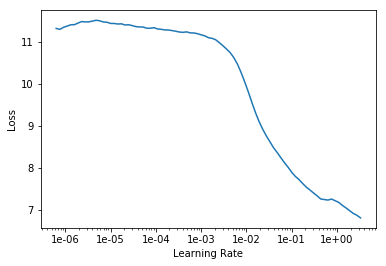

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5, 1e-04 , wd = 0.2)
#wd=0.2


epoch,train_loss,valid_loss,exp_rmspe,time
0,0.013862,0.014173,0.118426,02:34
1,0.014545,0.014126,0.114729,02:32
2,0.013185,0.012204,0.110214,02:33
3,0.010333,0.012740,0.107716,02:33
4,0.009316,0.011313,0.103339,02:33


In [0]:
learn.show_results()

Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,PromoInterval,CompetitionOpenSinceYear,Promo2SinceYear,State,Week,Events,Promo_fw,Promo_bw,StateHoliday_fw,StateHoliday_bw,SchoolHoliday_fw,SchoolHoliday_bw,CompetitionDistance_na,CloudCover_na,CompetitionDistance,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday,Promo,SchoolHoliday,target,prediction
1,5,2015,7,31,False,24,0,c,a,#na#,2008,1900,HE,31,Fog,5.0,5.0,0.0,0.0,7.0,5.0,False,False,-0.5358,1.0954,0.8912,0.3871,0.6029,-1.5678,-1.6598,0.1549,-0.1452,-2.8229,1.8567,1.8939,0.5940,1.1848,1.1119,2.0852,8.568457,[8.473851]
2,5,2015,7,31,False,24,25,a,a,"Jan,Apr,Jul,Oct",2007,2010,TH,31,Fog,1.0,5.0,0.0,0.0,1.0,5.0,False,False,-0.6255,0.6144,0.4683,0.2293,0.8653,-0.9545,-1.3033,-0.9548,-0.1452,-0.9761,1.4035,1.8939,0.9099,1.1848,1.1119,2.0852,8.710125,[8.63015]
3,5,2015,7,31,False,24,25,a,a,"Jan,Apr,Jul,Oct",2006,2011,NW,31,Fog,5.0,5.0,0.0,0.0,5.0,5.0,False,False,1.1122,0.8549,0.4683,0.0716,0.8653,-1.0312,-1.3542,-0.9548,-1.1514,-2.2073,1.9473,1.8939,0.5940,1.1848,1.1119,2.0852,9.025696,[9.06781]
4,5,2015,7,31,False,24,0,c,c,#na#,2009,1900,BE,31,#na#,1.0,5.0,0.0,0.0,1.0,5.0,False,False,-0.6191,0.6144,0.6092,0.5448,0.0780,-1.0312,-1.0487,0.0439,0.6933,0.2552,0.8597,1.8939,0.9099,1.1848,1.1119,2.0852,9.546455,[9.407496]
5,5,2015,7,31,False,3,0,a,a,#na#,2015,1900,SN,31,#na#,1.0,5.0,0.0,0.0,1.0,5.0,False,False,3.1344,0.7346,0.7502,0.7025,-1.4966,-1.4912,-1.2524,-0.9548,-0.1452,-0.9761,1.5848,1.8939,0.5940,1.1848,1.1119,2.0852,8.480944,[8.601124]


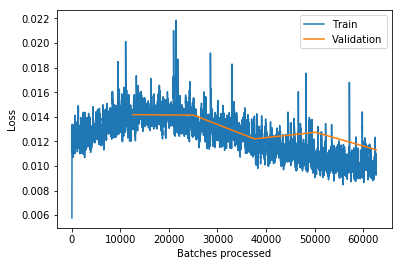

In [0]:
learn.recorder.plot_losses()

In [0]:
learn.save('1')

In [0]:
learn.load('1');

In [0]:
learn.fit_one_cycle(5, 2e-03)
#wd=0.2

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.018618,0.044001,0.148625,02:38
1,0.016045,0.016544,0.128594,02:37
2,0.014085,0.017345,0.132038,02:39
3,0.011832,0.023076,0.140298,02:37
4,0.011420,0.015482,0.139693,02:41


In [121]:
learn.fit_one_cycle(5 , 2e-03)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.014677,0.063601,0.115678,02:35
1,0.013906,0.025267,0.114628,02:34
2,0.011470,0.021514,0.117602,02:34
3,0.010975,0.175133,0.111382,02:33
4,0.010882,0.038462,0.117137,02:34


In [0]:
test_preds=learn.get_preds(DatasetType.Test)
test_df["Sales"]=np.exp(test_preds[0].data).numpy().T[0]
test_df[["Id","Sales"]]=test_df[["Id","Sales"]].astype("int")

In [0]:
test_preds

[tensor([[ 8.4181],
         [ 8.8689],
         [ 9.1817],
         ...,
         [ 8.7301],
         [10.1306],
         [ 8.8619]]), tensor([0, 0, 0,  ..., 0, 0, 0])]

In [0]:
test_df[["Id","Sales"]].to_csv("rossmann_submission.csv",index=False)

In [0]:
"""path = PATH
test_df.to_csv(path/'submission.csv', columns=["Id","Sales"], index=False)
sub = pd.read_csv(PATH/'submission.csv')
sub.head()"""

In [166]:
xy = pd.read_csv('rossmann_submission.csv')
xy.head()

,Id,Sales
0,1,4577
1,2,7000
2,3,9896
3,4,7616
4,5,7676


In [127]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yngspacecadet","key":"1e8d5f52cfacd4df7a24c5932f6514d9"}'}

In [157]:
 ! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [0]:
# This permissions change avoids a warning on Kaggle tool startup.
#Change the permissions of the file.
!chmod 600 ~/.kaggle/kaggle.json

In [160]:
!kaggle competitions submit -c rossmann-store-sales -f rossmann_submission.csv -m "Message"

100% 434k/434k [00:09<00:00, 47.1kB/s]
b
Successfully submitted to Rossmann Store Sales

In [0]:
train_preds=learn.get_preds(DatasetType.Train)